In [1]:
# MINIMALLY, NEED PARQUETS TO RUN FROM "START HERE" CELL
# RUN ONLY THIS CELL IF HAVE PARQUETS AND NOT GENERATING PARQUETS FROM SCRATCH
import pandas as pd
import sqlite3
import math
import matplotlib.pyplot as plt
import os

# uses positioning information from GeoNames (https://www.geonames.org) to find landfall country/state from coordinates
# GeoNames database from https://download.geonames.org/export/dump/
# need US, Mexico, and Canada to differentiate landfalls that are close
geonames_dbs_txt = ['US/US.txt', 'MX/MX.txt', 'CA/CA.txt']
# this will be created in the cell below
geonames_db_sqlite = 'USMXCA.sqlite'

# best track data from https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/
best_tracks_na_csv = 'ibtracs.NA.list.v04r00.csv'
best_tracks_ep_csv = 'ibtracs.EP.list.v04r00.csv'

# Constants for Earth's radius in kilometers
EARTH_RADIUS_KM = 6371.0

# for calculating probabilities
default_start_year = 1851
default_end_year = 2002

# Function to calculate the Haversine distance between two coordinates
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = EARTH_RADIUS_KM * c

    return distance


def find_nearest_country_and_state(conn, lat, lon):
    cursor = conn.cursor()
    
    # Query the database to find the nearest place based on coordinates
    cursor.execute("""
        SELECT country, state, latitude, longitude FROM geonames
        WHERE latitude BETWEEN ? AND ?
        AND longitude BETWEEN ? AND ?
        ORDER BY ((latitude - ?) * (latitude - ?) + (longitude - ?) * (longitude - ?))
        LIMIT 1
    """, (lat - 1, lat + 1, lon - 1, lon + 1, lat, lat, lon, lon))

    result = cursor.fetchone()
    cursor.close()

    if result:
        country, state, place_lat, place_lon = result
        if str(state) != '00':
            distance = haversine_distance(lat, lon, place_lat, place_lon)
            return country, state, distance

    return None, None, None

# create a new empty dataframe with same template
def copy_df_structure(df_reference):
    new_df = df_reference.copy(deep=False)
    new_df.astype(df_reference.dtypes.to_dict())
    new_df = new_df[0:0]
    return new_df

# add landfall state for all US tropical storms and subtropical storms
def get_us_landfalls(df_reference):
    df_new_landfalls = copy_df_structure(df_reference)
    df_new_landfalls.reset_index()
    US_state_abbrevs = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

    # Connect to the SQLite database containing Geonames data
    conn = sqlite3.connect(geonames_db_sqlite)
    us_state_landfalls = []
    for i in range(len(df_reference)):
        entry = df_reference.iloc[i]
        latitude = float(entry['USA_LAT'])
        longitude = float(entry['USA_LON'])

        country, state, distance_km = find_nearest_country_and_state(conn, latitude, longitude)
        # it may return state='00' if Mexico is not in sqlite database so double check state is in abbrevs
        if country == 'US' and state in US_state_abbrevs:
            df_new_landfalls.loc[len(df_new_landfalls)] = entry
            df_new_landfalls.reset_index()
            us_state_landfalls.append(state)

    # Don't forget to close the database connection when you're done
    conn.close()

    df_new_landfalls.reset_index()
    df_new_landfalls_with_state = df_new_landfalls.copy(deep=True)
    df_new_landfalls_with_state = df_new_landfalls_with_state.assign(LANDFALL_STATE=us_state_landfalls)
    return df_new_landfalls_with_state

# get the df with us landfall states (or the unique storms when no state supplied), selected by:
#     start/end year,
#     a list of US states where landfall occured (must be a list)
#     from a range within each year (start/end month and day; both must be supplied)
def get_landfalling_conditional(df_reference, states=None,
                                start_year=default_start_year, end_year=default_end_year,
                                start_month_num=None, start_day_num_of_month=None,
                                end_month_num=None, end_day_num_of_month=None):
    # might have multiple landfalls with the same storm, so only count each storm once
    df_new = df_reference.copy(deep=True)
    year_range = list(range(start_year, end_year + 1, 1))
    if states is not None:
        df_new = df_new.loc[(df_new['SEASON'].isin(year_range)) & (df_new['LANDFALL_STATE'].isin(states))]
    else:
        df_new = df_new.loc[(df_new['SEASON'].isin(year_range))]
    df_new.reset_index()
    # get the mataching year and state first, then drop storm duplicates
    df_new = df_new.drop_duplicates(subset=['USA_ATCF_ID'])
    df_new.reset_index()
    if start_month_num and end_month_num and start_day_num_of_month and end_day_num_of_month:
        # Only include those within the month-day range (inclusive)
        df_new['month'] = df_new['ISO_TIME'].dt.month
        df_new['day'] = df_new['ISO_TIME'].dt.day
        df_new['month_day_sum'] = (df_new['month'] * 100) + df_new['day']
        start_month_day_sum = (start_month_num * 100) + start_day_num_of_month
        end_month_day_sum = (end_month_num * 100) + end_day_num_of_month
        df_new = df_new.loc[
            (df_new['month_day_sum'] >= start_month_day_sum) &
            (df_new['month_day_sum'] <= end_month_day_sum)
        ]
        df_new.reset_index()

    return df_new

# calculate expected probability for exactly expected_num_events this year, given:
#   that a total of num_events have happened over num_years
def poisson_pmf(num_years, num_events, expected_num_events):
    p = num_events / num_years
    xfact = math.factorial(expected_num_events)
    ep = math.pow(p, expected_num_events) / (math.exp(p) * xfact)
    return ep

In [ ]:

















############################################### 
#### VERY SLOW ... SKIP TO "START HERE"
###############################################























In [ ]:
# create the geonames db (only do once!)

## ONLY RUN THIS CELL ONCE
if not os.path.isfile(geonames_db_sqlite):
    # Create a new SQLite database or connect to an existing one
    conn = sqlite3.connect(geonames_db_sqlite)
    cursor = conn.cursor()

    # Create a table to store the Geonames data
    cursor.execute('''
        CREATE TABLE geonames (
            geonameid INTEGER PRIMARY KEY,
            name TEXT,
            latitude REAL,
            longitude REAL,
            country TEXT,
            state TEXT
        )
    ''')

    for geonames_db_txt in geonames_dbs_txt:
        # Read and import data from the "US.txt" file into the database
        with open(geonames_db_txt, 'r', encoding='utf-8') as file:
            for line in file:
                parts = line.strip().split('\t')
                if len(parts) >= 10:
                    geonameid, name, latitude, longitude, country, state = (
                        int(parts[0]), parts[1], float(parts[4]), float(parts[5]), parts[8], parts[10]
                    )
                    cursor.execute('''
                        INSERT INTO geonames (geonameid, name, latitude, longitude, country, state)
                        VALUES (?, ?, ?, ?, ?, ?)
                    ''', (geonameid, name, latitude, longitude, country, state))

    # Commit changes and close the database connection
    conn.commit()
    conn.close()


In [ ]:
#############################################################################
# READ THE TRACKS AND DO THE LANDFALL CALCULATIONS IN BELOW CELLS (VERY SLOW)
# ONLY NEED TO DO ONCE SINCE PARQUETS ARE PRECOMPUTED
#############################################################################

In [ ]:
# Read the CSV file into a DataFrame without automatically assigning column names
df_na = pd.read_csv(best_tracks_na_csv, header=0, skiprows=[1], low_memory=False)
df_ep = pd.read_csv(best_tracks_ep_csv, header=0, skiprows=[1], low_memory=False)
# store all related basin dataframes in one list, with the main one (read from file) separately
dfs_by_basin = {'NA': {'main': df_na}, 'EP': {'main': df_ep}}

In [ ]:
# get landfalls for ts/ss/hu (>=34kt) and compute landfall states for both basins (north atlantic and east pacific)
#   only include rows with unique landfall state/storm combinations:
#      don't have rows for storm that have landfalling twice in same storm
#   so, there may be multiple landfalls per storm if a storm landfalls in multiple states,
#      but each state will have a specific storm landfalling only once in that state
for basin_name, dict_dfs in dfs_by_basin.items():
    df = dict_dfs['main'].copy(deep=True)
    # Create a dictionary that specifies the data types for each column
    dtype_mapping = {
        'LAT': float,
        'LON': float,
        'WMO_WIND': float,
        'WMO_PRES': float,
        'USA_WIND': float,
        'DIST2LAND': float,
        'LANDFALL': float,
        'STORM_SPEED': float,
        'STORM_DIR': float
    }

    # Apply dtype conversion to specific columns, treating non-numeric values as NaN
    for column, data_type in dtype_mapping.items():
        df[column] = pd.to_numeric(df[column], errors='coerce').astype(data_type)

    # convert time to datetime
    df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])

    # get landfalls
    df_landfalls = df.loc[(df['USA_RECORD'] == 'L')]
    df_ts_ss_landfalls = df_landfalls.loc[(df_landfalls['USA_WIND'] >= 34) & (df_landfalls['USA_STATUS'].isin(['TS', 'SS']))]
    df_hu_landfalls = df_landfalls.loc[(df_landfalls['USA_WIND'] >= 34) & (df_landfalls['USA_STATUS'].isin(['HU', 'HR']))]
    df_landfalls.reset_index()
    df_ts_ss_landfalls.reset_index()
    df_hu_landfalls.reset_index()
    
    # this will take a while as geonames is slow
    df_us_ts_ss_landfalls_with_state = get_us_landfalls(df_ts_ss_landfalls)
    df_us_hu_landfalls_with_state = get_us_landfalls(df_hu_landfalls)
    
    # for the above landfalls there are duplicates for a single state with different timestamps
    df_us_ts_ss_landfalls_with_state_no_dupe_times = df_us_ts_ss_landfalls_with_state.drop_duplicates(subset=['LANDFALL_STATE', 'USA_ATCF_ID'])
    df_us_hu_landfalls_with_state_no_dupe_times = df_us_hu_landfalls_with_state.drop_duplicates(subset=['LANDFALL_STATE', 'USA_ATCF_ID'])
    df_us_ts_ss_hu_landfalls_with_state_no_dupe_times = pd.concat([df_us_ts_ss_landfalls_with_state_no_dupe_times, df_us_hu_landfalls_with_state_no_dupe_times])
    df_us_ts_ss_hu_landfalls_with_state_no_dupe_times = df_us_ts_ss_hu_landfalls_with_state_no_dupe_times.drop_duplicates(subset=['LANDFALL_STATE', 'USA_ATCF_ID'])

    dict_dfs['us_landfalls_ts_ss'] = df_us_ts_ss_landfalls_with_state_no_dupe_times
    dict_dfs['us_landfalls_hu'] = df_us_hu_landfalls_with_state_no_dupe_times
    dict_dfs['us_landfalls_ts_ss_hu'] = df_us_ts_ss_hu_landfalls_with_state_no_dupe_times
    dfs_by_basin[basin_name] = dict_dfs

In [ ]:
# get ts/ss/hu storms (>=34kt) for both basins (north atlantic and east pacific)
for basin_name, dict_dfs in dfs_by_basin.items():
    df = dict_dfs['main'].copy(deep=True)
    # Create a dictionary that specifies the data types for each column
    dtype_mapping = {
        'LAT': float,
        'LON': float,
        'WMO_WIND': float,
        'WMO_PRES': float,
        'USA_WIND': float,
        'DIST2LAND': float,
        'LANDFALL': float,
        'STORM_SPEED': float,
        'STORM_DIR': float
    }

    # Apply dtype conversion to specific columns, treating non-numeric values as NaN
    for column, data_type in dtype_mapping.items():
        df[column] = pd.to_numeric(df[column], errors='coerce').astype(data_type)

    # convert time to datetime
    df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])

    # get landfalls
    df_ts_ss = df.loc[(df['USA_WIND'] >= 34) & (df['USA_STATUS'].isin(['TS', 'SS']))]
    df_hu = df.loc[(df['USA_WIND'] >= 34) & (df['USA_STATUS'].isin(['HU', 'HR']))]
    df_ts_ss.reset_index()
    df_hu.reset_index()
    df_ts_ss_hu = pd.concat([df_ts_ss,df_hu])
    df_ts_ss_hu.reset_index()    
    
    dict_dfs['ts_ss'] = df_ts_ss
    dict_dfs['hu'] = df_hu
    dict_dfs['ts_ss_hu'] = df_ts_ss_hu
    dfs_by_basin[basin_name] = dict_dfs

In [ ]:
# write the parquets
for basin_name, dict_dfs in dfs_by_basin.items():
    for df_name, dict_df in dict_dfs.items():
        parquet_name = basin_name + '_basin_' + df_name + ".parquet"
        dict_df.to_parquet(parquet_name)

In [ ]:
print(dfs_by_basin['NA'].keys())
print(dfs_by_basin['EP'].keys())

In [ ]:
# COMBINE NA AND EP for US landfalling storms

# do for both basins (north atlantic and east pacific)
# because of the import NA got imported as nan
dfs_na_ep_us_landfalls = {}
dfs_tmp = {
    'ts_ss': [],
    'hu': [],
    'ts_ss_hu': []
}
# includes storms that cross basins
for basin_name, dict_dfs in dfs_by_basin.items():
    # get storms    
    df_us_landfalls_ts_ss = dict_dfs['us_landfalls_ts_ss'].copy(deep=True)
    df_us_landfalls_hu = dict_dfs['us_landfalls_hu'].copy(deep=True)
    df_us_landfalls_ts_ss_hu = dict_dfs['us_landfalls_ts_ss_hu'].copy(deep=True)
    
    dfs_tmp['ts_ss'].append(df_us_landfalls_ts_ss)
    dfs_tmp['hu'].append(df_us_landfalls_hu)
    dfs_tmp['ts_ss_hu'].append(df_us_landfalls_ts_ss_hu)

# concat the dfs for the basins
for dict_name, dict_dfs in dfs_tmp.items():
    dfs_na_ep_us_landfalls[dict_name] = pd.concat(dict_dfs)
    dfs_na_ep_us_landfalls[dict_name].reset_index()

In [ ]:
# write the parquets
for df_name, dict_df in dfs_na_ep_us_landfalls.items():
    parquet_name = 'na_ep_us_landfalls_' + df_name + ".parquet"
    dict_df.to_parquet(parquet_name)

In [ ]:
# COMBINE NA AND EP for all storms

# do for both basins (north atlantic and east pacific)
# because of the import NA got imported as nan
dfs_na_ep = {}
dfs_tmp = {
    'ts_ss': [],
    'hu': [],
    'ts_ss_hu': []
}
# includes storms that cross basins
for basin_name, dict_dfs in dfs_by_basin.items():
    # get storms    
    df_ts_ss = dict_dfs['ts_ss'].copy(deep=True)
    df_hu = dict_dfs['hu'].copy(deep=True)
    df_ts_ss_hu = dict_dfs['ts_ss_hu'].copy(deep=True)
    
    dfs_tmp['ts_ss'].append(df_ts_ss)
    dfs_tmp['hu'].append(df_hu)
    dfs_tmp['ts_ss_hu'].append(df_ts_ss_hu)

# concat the dfs for the basins
for dict_name, dict_dfs in dfs_tmp.items():
    dfs_na_ep[dict_name] = pd.concat(dict_dfs)
    dfs_na_ep[dict_name].reset_index()

In [ ]:
# write the parquets
for df_name, dict_df in dfs_na_ep.items():
    parquet_name = 'na_ep_' + df_name + ".parquet"
    #print(parquet_name)
    dict_df.to_parquet(parquet_name)

In [2]:























#######################
##### START HERE ######
#######################

# FIRST, RUN THE FIRST CELL, THEN THESE BELOW















In [3]:
# LOAD THE PARQUETS BY BASIN 

parquets_by_basin_for_us_landfalls = [
'EP_basin_main.parquet',
'EP_basin_us_landfalls_ts_ss.parquet',
'EP_basin_us_landfalls_hu.parquet',
'EP_basin_us_landfalls_ts_ss_hu.parquet',
'EP_basin_ts_ss.parquet',
'EP_basin_hu.parquet',
'EP_basin_ts_ss_hu.parquet',
'NA_basin_main.parquet',
'NA_basin_us_landfalls_ts_ss.parquet',
'NA_basin_us_landfalls_hu.parquet',
'NA_basin_us_landfalls_ts_ss_hu.parquet',
'NA_basin_ts_ss.parquet',
'NA_basin_hu.parquet',
'NA_basin_ts_ss_hu.parquet',
]

dfs_by_basin = {}
for parquet_file_name in parquets_by_basin_for_us_landfalls:
    parquet_name = parquet_file_name.replace(".parquet", "")
    basin_name, df_name = parquet_name.split('_basin_')
    if basin_name not in dfs_by_basin:
        dfs_by_basin[basin_name] = {}
    dict_dfs = dfs_by_basin[basin_name]
    dict_dfs[df_name] = pd.read_parquet(parquet_file_name)
    dfs_by_basin[basin_name] = dict_dfs

In [4]:
# LOAD THE PARQUETS BY STORM TYPES FOR US LANDFALLS

parquets_by_storm_types_for_us_landfalls = [
'na_ep_us_landfalls_hu.parquet',
'na_ep_us_landfalls_ts_ss.parquet',
'na_ep_us_landfalls_ts_ss_hu.parquet'
]

dfs_na_ep_us_landfalls = {}
for parquet_file_name in parquets_by_storm_types_for_us_landfalls:
    parquet_name = parquet_file_name.replace(".parquet", "")
    prefix, df_name = parquet_name.split('na_ep_us_landfalls_')
    dfs_na_ep_us_landfalls[df_name] = pd.read_parquet(parquet_file_name)

In [5]:
# LOAD THE PARQUETS BY STORM TYPES FOR ALL STORMS

parquets_by_storm_types = [
'na_ep_hu.parquet',
'na_ep_ts_ss.parquet',
'na_ep_ts_ss_hu.parquet'
]

dfs_na_ep = {}
for parquet_file_name in parquets_by_storm_types:
    parquet_name = parquet_file_name.replace(".parquet", "")
    prefix, df_name = parquet_name.split('na_ep_')
    dfs_na_ep[df_name] = pd.read_parquet(parquet_file_name)

# US Named Storm landfalls (>=34 kt) in records from North Atlantic and East Pacific basins: 516
# US Named Storm landfalls (>=34 kt) from North Atlantic and East Pacific basins, 1991 to 2022 from 10-13 to 11-30 in all US states: 7
PMF % (starting from 0): [80.35225736890607, 17.577056299448202, 1.9224905327521473, 0.14018160134651073, 0.007666181323637305, 0.00033539543290913215, 1.2227958491478776e-05, 3.8212370285871175e-07, 1.04486950000429e-08, 2.539613368065982e-10]
Cumulative % (starting from 0): [99.99999999999434, 19.647742631088278, 2.0706863316400757, 0.14819579888792833, 0.008014197541417606, 0.0003480162177803012, 1.2620784871169059e-05, 3.9282637969028267e-07, 1.070267683157092e-08, 2.539818315280198e-10]


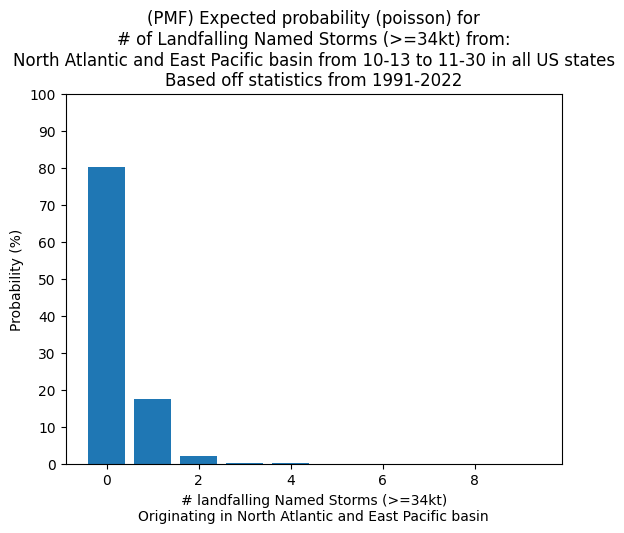

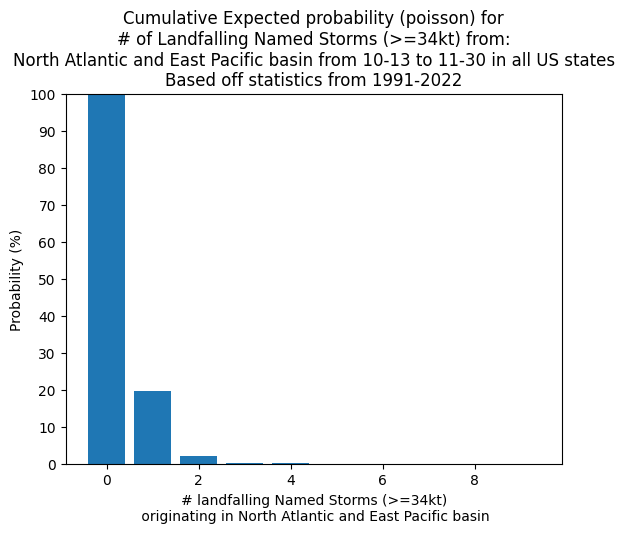

In [6]:
##### COMBINED NA AND EP BASIN STATISTICS FOR US LANDFALLS FOR NAMED STORMS (>= 34kt)
# set optionally either to None (default 1991-2022)
start_year = 1991
end_year = 2022
# must include all as None or with numbered month and day
start_month = None
start_day = None
end_month = None
end_day = None
start_month = 10
start_day = 13
end_month = 11
end_day = 30
# either None, or a list of 2 letter states to include
states = None
#states = ['NY', 'NJ']

if start_month and start_day and end_month and end_day:
    sub_period_str = f'from {start_month}-{start_day} to {end_month}-{end_day}'
else:
    sub_period_str = 'in a year'

states_str = 'in '
if states:
    states_str += ','.join(states)
else:
    states_str += 'all US states'

full_basin_name = "North Atlantic and East Pacific"

df_ref_with_state = dfs_na_ep_us_landfalls['ts_ss_hu'].copy(deep=True)
    
# with state has duplicate rows to record storms with multiple landfalls, so get only the unique storms for a count
df_unique_storms = df_ref_with_state.drop_duplicates(subset=['USA_ATCF_ID'])
df_unique_storms.reset_index()
print(f"# US Named Storm landfalls (>=34 kt) in records from {full_basin_name} basins:", len(df_unique_storms))

landfalling_in_period = get_landfalling_conditional(
    df_ref_with_state,
    states=states,
    start_year=start_year, end_year=end_year,
    start_month_num=start_month, start_day_num_of_month=start_day,
    end_month_num=end_month, end_day_num_of_month=end_day
)
#print(landfalling_in_period)
num_years = (end_year - start_year + 1)
num_in_period = len(landfalling_in_period)
print(f"# US Named Storm landfalls (>=34 kt) from {full_basin_name} basins, {start_year} to {end_year} {sub_period_str} {states_str}:", num_in_period)

event_counts = list(range(0,10))
pmf_pct_per_event_count = []
cum_pct_per_event_count = []
pct_total = 0
for n in event_counts:
    pct = 100 * poisson_pmf(num_years, num_in_period, n)
    pct_total += pct
    pmf_pct_per_event_count.append(pct)

remaining_pct = pct_total
# get cumulative probability from pmf
for pct in pmf_pct_per_event_count:
    cum_pct_per_event_count.append(remaining_pct)
    remaining_pct = remaining_pct - pct

print("PMF % (starting from 0):", pmf_pct_per_event_count)
print("Cumulative % (starting from 0):", cum_pct_per_event_count)

# Create a bar chart
plt.bar(event_counts, pmf_pct_per_event_count)

plt.ylim(0, 100)
plt.yticks(range(0, 101, 10))

# Label the axes and give the chart a title
plt.xlabel(f'# landfalling Named Storms (>=34kt)\nOriginating in {full_basin_name} basin')
plt.ylabel('Probability (%)')
plt.title(f"(PMF) Expected probability (poisson) for\n# of Landfalling Named Storms (>=34kt) from:\n" +
          f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
          f"Based off statistics from {start_year}-{end_year}")

# Show the chart
plt.show()

# Cumulative Probabilities chart
plt.bar(event_counts, cum_pct_per_event_count)

plt.ylim(0, 100)
plt.yticks(range(0, 101, 10))

# Label the axes and give the chart a title
plt.xlabel(f'# landfalling Named Storms (>=34kt)\n originating in {full_basin_name} basin')
plt.ylabel('Probability (%)')
plt.title(f"Cumulative Expected probability (poisson) for\n# of Landfalling Named Storms (>=34kt) from:\n" +
          f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
          f"Based off statistics from {start_year}-{end_year}")
plt.show()

# US Tropical/Subtropical Storm landfalls in records from East Pacific basin: 2
# US Tropical/Subtropical Storm landfalls from East Pacific basin, 1991 to 2022 from 11-1 to 11-30 in all US states: 0
PMF % (starting from 0): [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Cumulative % (starting from 0): [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


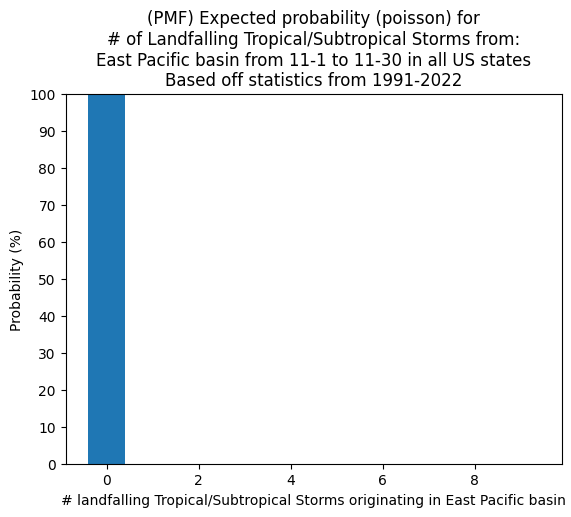

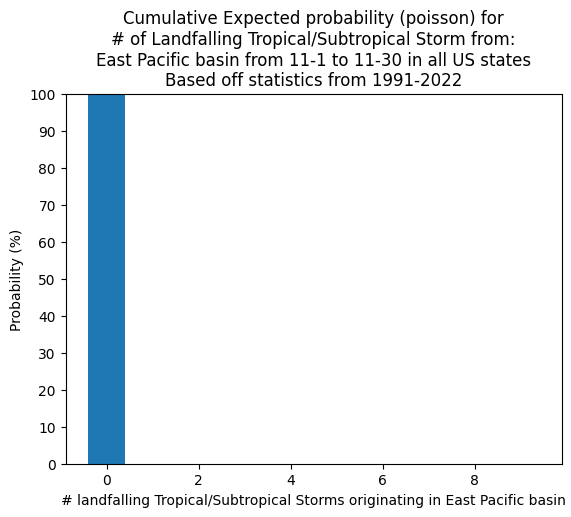

# US Hurricane landfalls in records from East Pacific basin: 4
# US Hurricane landfalls from East Pacific basin, 1991 to 2022 from 11-1 to 11-30 in all US states: 0
PMF % (starting from 0): [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Cumulative % (starting from 0): [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


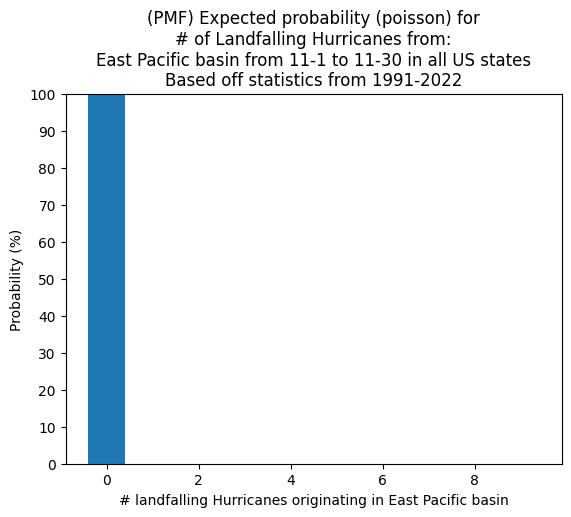

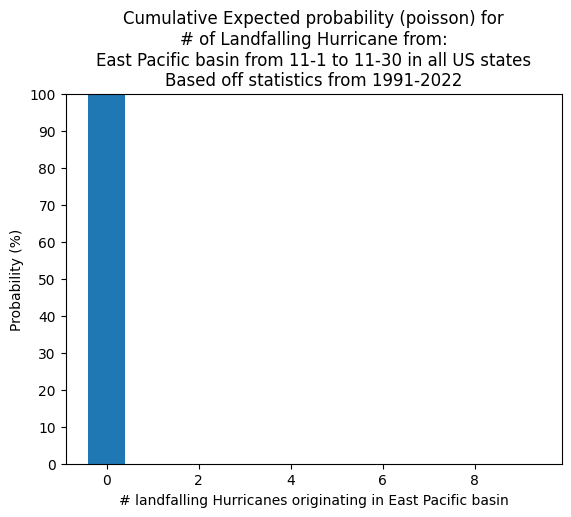

# US Tropical/Subtropical Storm landfalls in records from North Atlantic basin: 273
# US Tropical/Subtropical Storm landfalls from North Atlantic basin, 1991 to 2022 from 11-1 to 11-30 in all US states: 4
PMF % (starting from 0): [88.24969025845954, 11.031211282307442, 0.6894507051442151, 0.0287271127143423, 0.0008977222723231969, 2.2443056808079923e-05, 4.6756368350166506e-07, 8.34935149110116e-09, 1.3045861704845562e-10, 1.811925236784106e-12]
Cumulative % (starting from 0): [99.99999999999996, 11.75030974154042, 0.7190984592329777, 0.029647754088762523, 0.0009206413744202238, 2.2919102097026947e-05, 4.760452889470245e-07, 8.481605445359421e-09, 1.3225395425826112e-10, 1.7953372098054954e-12]


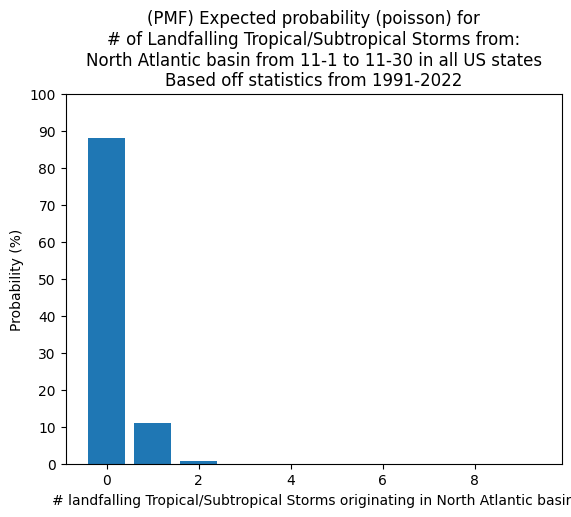

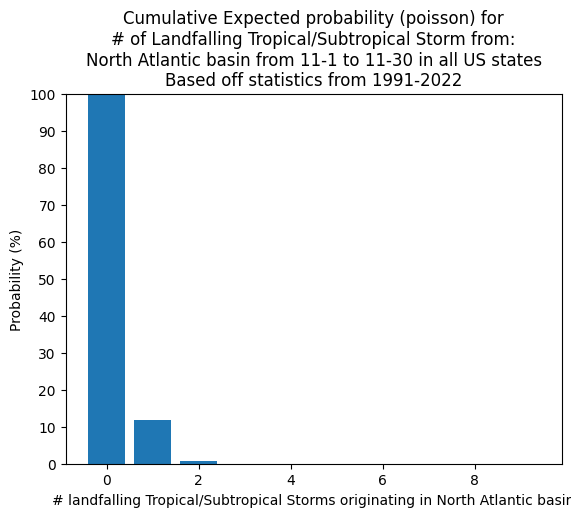

# US Hurricane landfalls in records from North Atlantic basin: 272
# US Hurricane landfalls from North Atlantic basin, 1991 to 2022 from 11-1 to 11-30 in all US states: 1
PMF % (starting from 0): [96.9233234476344, 3.028853857738575, 0.047325841527165236, 0.0004929775159079712, 3.851386843031025e-06, 2.4071167768943906e-08, 1.2537066546324952e-10, 5.596904708180781e-13, 2.1862909016331177e-15, 7.59128785289277e-18]
Cumulative % (starting from 0): [99.99999999999997, 3.0766765523655693, 0.04782269462699418, 0.0004968530998289422, 3.87558392097101e-06, 2.4197077939984652e-08, 1.25910171040746e-10, 5.395055774964782e-13, -2.0184893321599928e-14, -2.2371184223233047e-14]


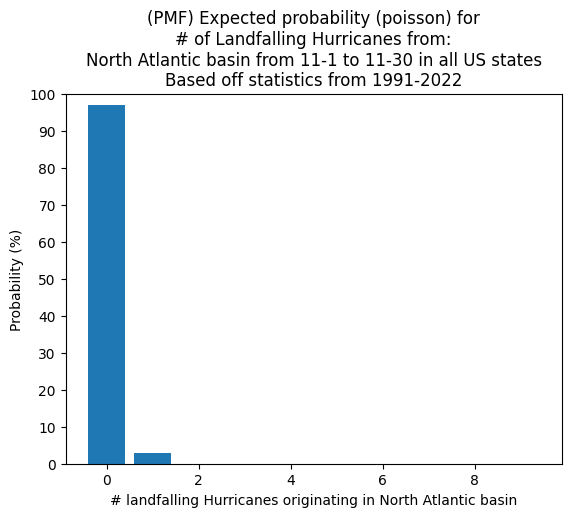

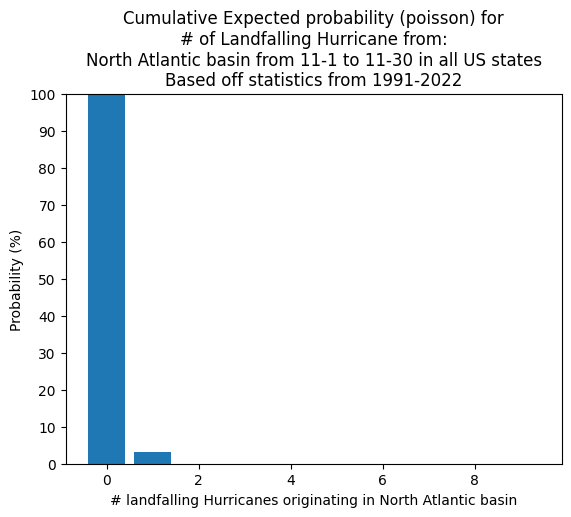

In [11]:
##### BY BASIN STATISTICS FOR US LANDFALLS
# set optionally either to None (default 1991-2022)
start_year = 1991
end_year = 2022
# must include all as None or with numbered month and day
start_month = None
start_day = None
end_month = None
end_day = None
start_month = 11
start_day = 1
end_month = 11
end_day = 30
# either None, or a list of 2 letter states to include
states = None
#states = ['NJ', 'NY']

if start_month and start_day and end_month and end_day:
    sub_period_str = f'from {start_month}-{start_day} to {end_month}-{end_day}'
else:
    sub_period_str = 'in a year'
    
states_str = 'in '
if states:
    states_str += ','.join(states)
else:
    states_str += 'all US states'
    
for basin_name, dict_dfs in dfs_by_basin.items():
    storm_types = {'TS/SS': 'Tropical/Subtropical Storm', 'HU': "Hurricane"}
    storm_type_short_to_dict_key_mapping = {'TS/SS': 'us_landfalls_ts_ss', 'HU': 'us_landfalls_hu'}
    basin_mapping = {'NA': 'North Atlantic', 'EP': 'East Pacific'}
    full_basin_name = basin_mapping[basin_name]    
    for storm_type_short, storm_type_long in storm_types.items():
        df_ref_with_state = dict_dfs[storm_type_short_to_dict_key_mapping[storm_type_short]].copy(deep=True)
        # with state has duplicate rows to record storms with multiple landfalls, so get only the unique storms for a count
        df_unique_storms = df_ref_with_state.drop_duplicates(subset=['USA_ATCF_ID'])
        df_unique_storms.reset_index()
        print(f"# US {storm_type_long} landfalls in records from {full_basin_name} basin:", len(df_unique_storms))
        
        landfalling_in_period = get_landfalling_conditional(
            df_ref_with_state,
            states=states,
            start_year=start_year, end_year=end_year,
            start_month_num=start_month, start_day_num_of_month=start_day,
            end_month_num=end_month, end_day_num_of_month=end_day
        )

        num_years = (end_year - start_year + 1)
        num_in_period = len(landfalling_in_period)
        print(f"# US {storm_type_long} landfalls from {full_basin_name} basin, {start_year} to {end_year} {sub_period_str} {states_str}:", num_in_period)

        event_counts = list(range(0,10))
        pmf_pct_per_event_count = []
        cum_pct_per_event_count = []
        pct_total = 0
        for n in event_counts:
            pct = 100 * poisson_pmf(num_years, num_in_period, n)
            pct_total += pct
            pmf_pct_per_event_count.append(pct)

        remaining_pct = pct_total
        # get cumulative probability from pmf
        for pct in pmf_pct_per_event_count:
            cum_pct_per_event_count.append(remaining_pct)
            remaining_pct = remaining_pct - pct
        
        print("PMF % (starting from 0):", pmf_pct_per_event_count)
        print("Cumulative % (starting from 0):", cum_pct_per_event_count)
        # Create a bar chart
        # PMF
        plt.bar(event_counts, pmf_pct_per_event_count)
        
        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 10))

        # Label the axes and give the chart a title
        plt.xlabel(f'# landfalling {storm_type_long}s originating in {full_basin_name} basin')
        plt.ylabel('Probability (%)')
        plt.title(f"(PMF) Expected probability (poisson) for\n# of Landfalling {storm_type_long}s from:\n" +
                  f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
                  f"Based off statistics from {start_year}-{end_year}")

        # Show the chart
        plt.show()
        
        # Cumulative Probabilities chart
        plt.bar(event_counts, cum_pct_per_event_count)

        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 10))

        # Label the axes and give the chart a title
        plt.xlabel(f'# landfalling {storm_type_long}s originating in {full_basin_name} basin')
        plt.ylabel('Probability (%)')
        plt.title(f"Cumulative Expected probability (poisson) for\n# of Landfalling {storm_type_long} from:\n" +
                  f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
                  f"Based off statistics from {start_year}-{end_year}")
        plt.show()

# US Tropical/Subtropical Storms (>=34 kt) landfalls in records from North Atlantic and East Pacific basins: 274
# US Tropical/Subtropical Storms (>=34 kt) landfalls from North Atlantic and East Pacific basins, 1991 to 2022 from 10-14 to 11-30 in all US states: 4
PMF % (starting from 0): [88.24969025845954, 11.031211282307442, 0.6894507051442151, 0.0287271127143423, 0.0008977222723231969, 2.2443056808079923e-05, 4.6756368350166506e-07, 8.34935149110116e-09, 1.3045861704845562e-10, 1.811925236784106e-12]
Cumulative % (starting from 0): [99.99999999999996, 11.75030974154042, 0.7190984592329777, 0.029647754088762523, 0.0009206413744202238, 2.2919102097026947e-05, 4.760452889470245e-07, 8.481605445359421e-09, 1.3225395425826112e-10, 1.7953372098054954e-12]


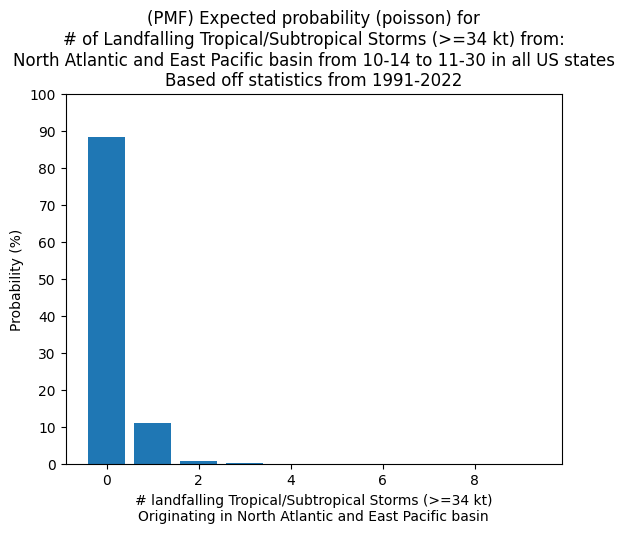

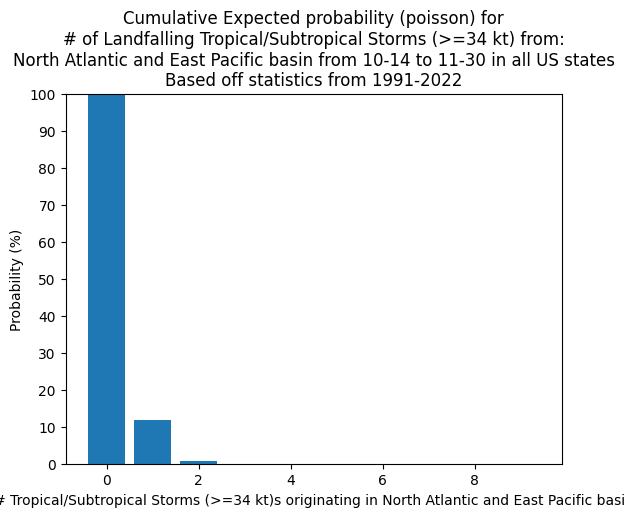

# US Hurricanes landfalls in records from North Atlantic and East Pacific basins: 273
# US Hurricanes landfalls from North Atlantic and East Pacific basins, 1991 to 2022 from 10-14 to 11-30 in all US states: 4
PMF % (starting from 0): [88.24969025845954, 11.031211282307442, 0.6894507051442151, 0.0287271127143423, 0.0008977222723231969, 2.2443056808079923e-05, 4.6756368350166506e-07, 8.34935149110116e-09, 1.3045861704845562e-10, 1.811925236784106e-12]
Cumulative % (starting from 0): [99.99999999999996, 11.75030974154042, 0.7190984592329777, 0.029647754088762523, 0.0009206413744202238, 2.2919102097026947e-05, 4.760452889470245e-07, 8.481605445359421e-09, 1.3225395425826112e-10, 1.7953372098054954e-12]


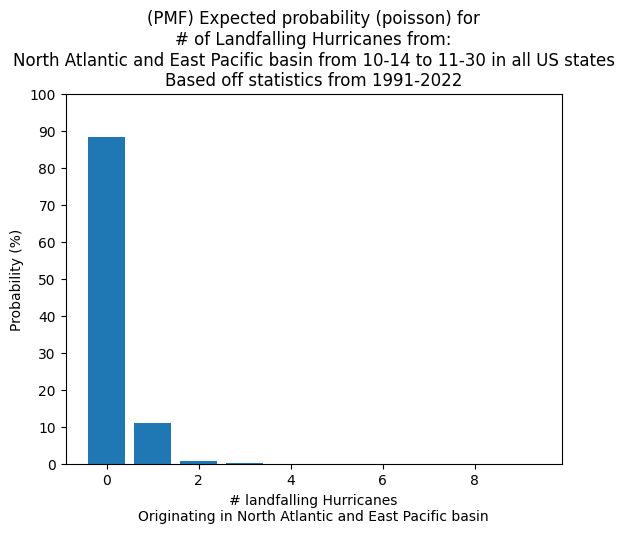

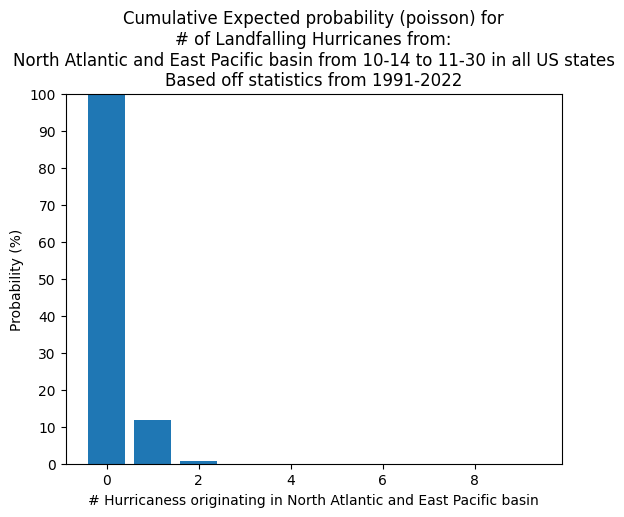

# US Named Storms (>=34 kt) landfalls in records from North Atlantic and East Pacific basins: 516
# US Named Storms (>=34 kt) landfalls from North Atlantic and East Pacific basins, 1991 to 2022 from 10-14 to 11-30 in all US states: 7
PMF % (starting from 0): [80.35225736890607, 17.577056299448202, 1.9224905327521473, 0.14018160134651073, 0.007666181323637305, 0.00033539543290913215, 1.2227958491478776e-05, 3.8212370285871175e-07, 1.04486950000429e-08, 2.539613368065982e-10]
Cumulative % (starting from 0): [99.99999999999434, 19.647742631088278, 2.0706863316400757, 0.14819579888792833, 0.008014197541417606, 0.0003480162177803012, 1.2620784871169059e-05, 3.9282637969028267e-07, 1.070267683157092e-08, 2.539818315280198e-10]


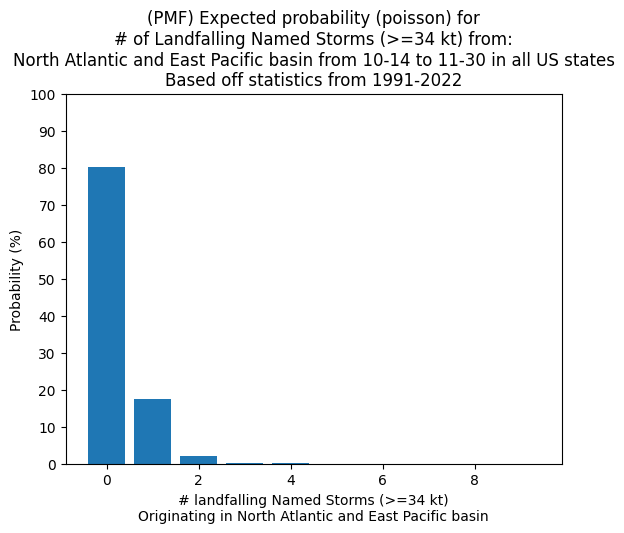

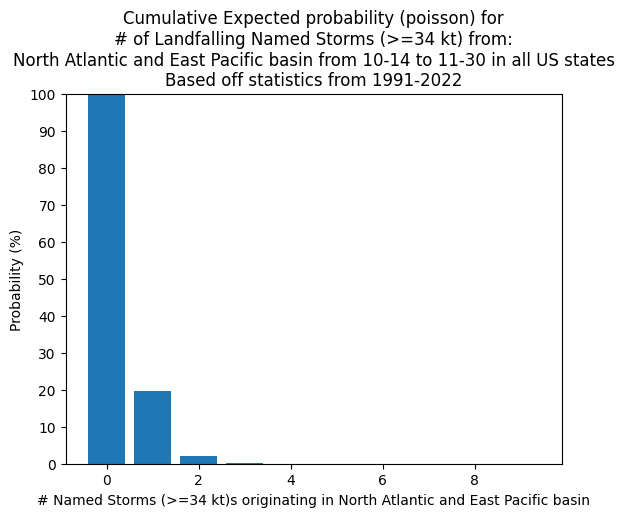

In [9]:
##### COMBINED NA AND EP BASIN STATISTICS FOR US LANDFALLS
# set optionally either to None (default 1991-2022)
start_year = 1991
end_year = 2022
# must include all as None or with numbered month and day
start_month = None
start_day = None
end_month = None
end_day = None
start_month = 10
start_day = 14
end_month = 11
end_day = 30
# either None, or a list of 2 letter states to include
states = None
#states = ['NY', 'NJ']

if start_month and start_day and end_month and end_day:
    sub_period_str = f'from {start_month}-{start_day} to {end_month}-{end_day}'
else:
    sub_period_str = 'in a year'
    
states_str = 'in '
if states:
    states_str += ','.join(states)
else:
    states_str += 'all US states'

full_basin_name = "North Atlantic and East Pacific"

storm_types = {'TS/SS': 'Tropical/Subtropical Storms (>=34 kt)', 'HU': "Hurricanes", 'TS/SS/HU': 'Named Storms (>=34 kt)'}
storm_type_short_to_dict_key_mapping = {'TS/SS': 'ts_ss', 'HU': 'hu', 'TS/SS/HU': 'ts_ss_hu'}
for storm_type_short, storm_type_long in storm_types.items():
    k = storm_type_short_to_dict_key_mapping[storm_type_short]
    df_ref_with_state = dfs_na_ep_us_landfalls[k].copy(deep=True)
    # with state has duplicate rows to record storms with multiple landfalls, so get only the unique storms for a count
    df_unique_storms = df_ref_with_state.drop_duplicates(subset=['USA_ATCF_ID'])
    df_unique_storms.reset_index()
    print(f"# US {storm_type_long} landfalls in records from {full_basin_name} basins:", len(df_unique_storms))

    landfalling_in_period = get_landfalling_conditional(
        df_ref_with_state,
        states=states,
        start_year=start_year, end_year=end_year,
        start_month_num=start_month, start_day_num_of_month=start_day,
        end_month_num=end_month, end_day_num_of_month=end_day
    )
    
    num_years = (end_year - start_year + 1)
    num_in_period = len(landfalling_in_period)
    print(f"# US {storm_type_long} landfalls from {full_basin_name} basins, {start_year} to {end_year} {sub_period_str} {states_str}:", num_in_period)

    event_counts = list(range(0,10))
    pmf_pct_per_event_count = []
    cum_pct_per_event_count = []
    pct_total = 0
    for n in event_counts:
        pct = 100 * poisson_pmf(num_years, num_in_period, n)
        pct_total += pct
        pmf_pct_per_event_count.append(pct)
            
    remaining_pct = pct_total
    # get cumulative probability from pmf
    for pct in pmf_pct_per_event_count:
        cum_pct_per_event_count.append(remaining_pct)
        remaining_pct = remaining_pct - pct

    print("PMF % (starting from 0):", pmf_pct_per_event_count)
    print("Cumulative % (starting from 0):", cum_pct_per_event_count)
    # Create a bar chart
    # PMF
    plt.bar(event_counts, pmf_pct_per_event_count)

    plt.ylim(0, 100)
    plt.yticks(range(0, 101, 10))

    # Label the axes and give the chart a title
    plt.xlabel(f'# landfalling {storm_type_long}\nOriginating in {full_basin_name} basin')
    plt.ylabel('Probability (%)')
    plt.title(f"(PMF) Expected probability (poisson) for\n# of Landfalling {storm_type_long} from:\n" +
              f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
              f"Based off statistics from {start_year}-{end_year}")

    # Show the chart
    plt.show()

    # Cumulative Probabilities chart
    plt.bar(event_counts, cum_pct_per_event_count)

    plt.ylim(0, 100)
    plt.yticks(range(0, 101, 10))

    # Label the axes and give the chart a title
    plt.xlabel(f'# {storm_type_long}s originating in {full_basin_name} basin')
    plt.ylabel('Probability (%)')
    plt.title(f"Cumulative Expected probability (poisson) for\n# of Landfalling {storm_type_long} from:\n" +
              f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
              f"Based off statistics from {start_year}-{end_year}")
    plt.show()

# US Tropical/Subtropical Storm in records from East Pacific basin: 1175
# US Tropical/Subtropical Storm from East Pacific basin, 1991 to 2022 from 10-9 to 11-30: 81
PMF % (starting from 0): [7.955950871822767, 20.13850064430138, 25.487789877943932, 21.505322709515195, 13.608837027115086, 6.8894737449770105, 2.9064967361621767, 1.0510099804872157, 0.3325461266385331, 0.09352859811708744, 0.02367442639838776, 0.005447808347356273, 0.001149147073270464, 0.00022375219455506625, 4.0455195890536544e-05, 6.826814306528041e-06, 1.080023357087444e-06, 1.6081230133103488e-07, 2.2614229874676774e-08, 3.0127510194881894e-09, 3.8130130090397396e-10, 4.5960424662532575e-11, 5.288060223956163e-12, 5.819740192125667e-13, 6.13800723388254e-14, 6.214732324306071e-15, 6.05040045996144e-16, 5.67225043121385e-17, 5.127815680003592e-18, 4.475787393106584e-19]
Cumulative % (starting from 0): [99.99999999999999, 92.04404912817722, 71.90554848387583, 46.4177586059319, 24.912435896416707, 11.30359886930162, 4.

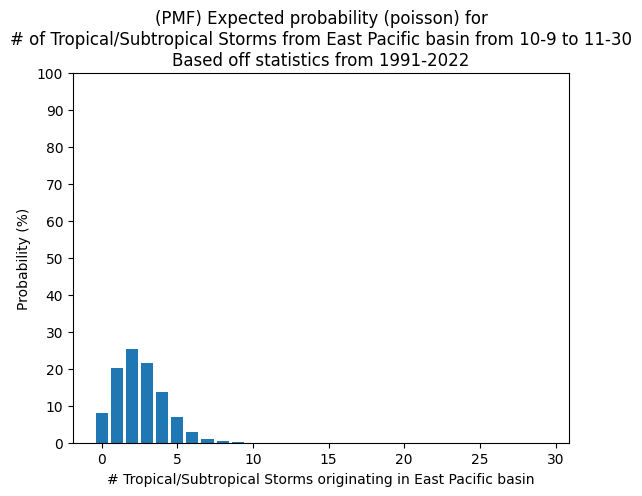

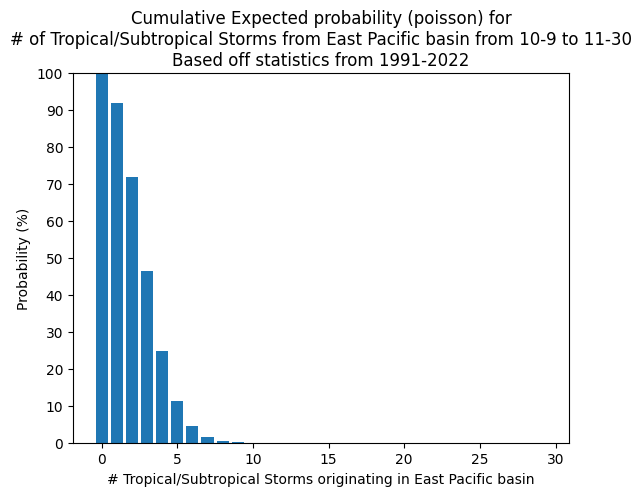

# US Hurricane in records from East Pacific basin: 598
# US Hurricane from East Pacific basin, 1991 to 2022 from 10-9 to 11-30: 31
PMF % (starting from 0): [37.95571881830895, 36.7696026052368, 17.810276261911575, 5.751235042908946, 1.3928772369545106, 0.26986996465993635, 0.0435727547107189, 0.006030158018001276, 0.000730214447492342, 7.859947177868958e-05, 7.614323828560553e-06, 6.705796553561852e-07, 5.413533676052536e-08, 4.0341236528276115e-09, 2.7914694919119637e-10, 1.8028240468598095e-11, 1.0915536221221504e-12, 6.220250420181372e-14, 3.347704219194835e-15, 1.7068886643921036e-16, 8.267741968149252e-18, 3.8139881103069466e-19, 1.6794549917544795e-20, 7.0737914054876145e-22, 2.8553064266942204e-23, 1.1064312403440103e-24, 4.122520246474076e-26, 1.4791449958413934e-27, 5.11757755257625e-29, 1.7095356048476696e-30]
Cumulative % (starting from 0): [99.99999999999999, 62.044281181691034, 25.274678576454235, 7.46440231454266, 1.713167271633714, 0.3202900346792035, 0.05042007001926713

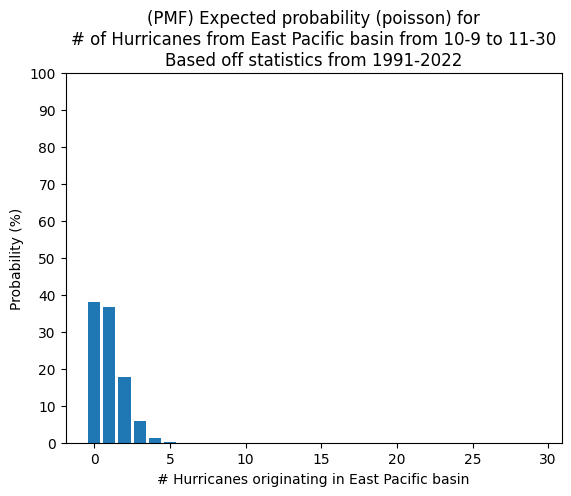

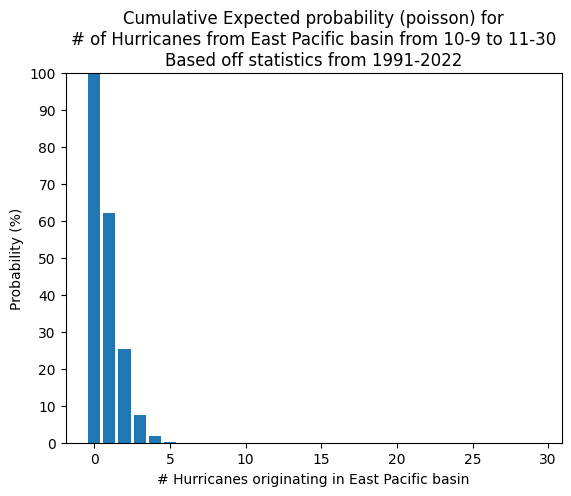

# US Named Storm in records from East Pacific basin: 1216
# US Named Storm from East Pacific basin, 1991 to 2022 from 10-9 to 11-30: 81
PMF % (starting from 0): [7.955950871822767, 20.13850064430138, 25.487789877943932, 21.505322709515195, 13.608837027115086, 6.8894737449770105, 2.9064967361621767, 1.0510099804872157, 0.3325461266385331, 0.09352859811708744, 0.02367442639838776, 0.005447808347356273, 0.001149147073270464, 0.00022375219455506625, 4.0455195890536544e-05, 6.826814306528041e-06, 1.080023357087444e-06, 1.6081230133103488e-07, 2.2614229874676774e-08, 3.0127510194881894e-09, 3.8130130090397396e-10, 4.5960424662532575e-11, 5.288060223956163e-12, 5.819740192125667e-13, 6.13800723388254e-14, 6.214732324306071e-15, 6.05040045996144e-16, 5.67225043121385e-17, 5.127815680003592e-18, 4.475787393106584e-19]
Cumulative % (starting from 0): [99.99999999999999, 92.04404912817722, 71.90554848387583, 46.4177586059319, 24.912435896416707, 11.30359886930162, 4.41412512432461, 1.507628388162

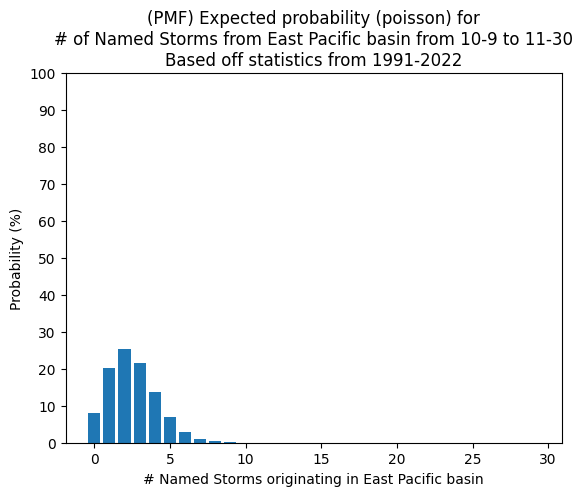

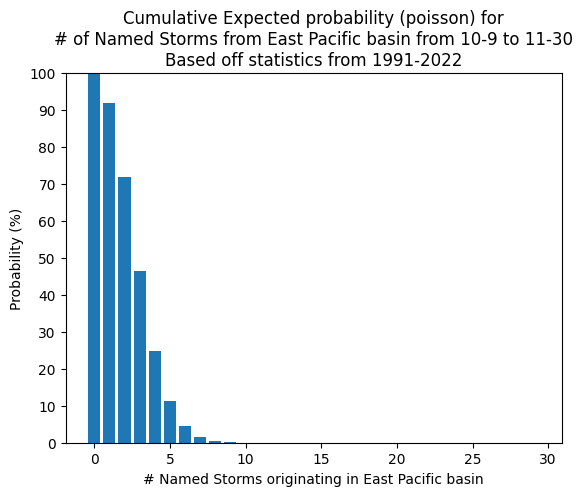

# US Tropical/Subtropical Storm in records from North Atlantic basin: 1689
# US Tropical/Subtropical Storm from North Atlantic basin, 1991 to 2022 from 10-9 to 11-30: 80
PMF % (starting from 0): [8.20849986238988, 20.5212496559747, 25.651562069968374, 21.376301724973644, 13.360188578108529, 6.6800942890542645, 2.783372620439277, 0.9940616501568845, 0.3106442656740264, 0.08629007379834068, 0.02157251844958517, 0.004902845102178447, 0.001021426062953843, 0.00019642808902958526, 3.507644446956879e-05, 5.8460740782614655e-06, 9.13449074728354e-07, 1.3433074628358143e-07, 1.8657048094941867e-08, 2.4548747493344564e-09, 3.0685934366680704e-10, 3.653087424604846e-11, 4.1512357097782344e-12, 4.512212728019819e-13, 4.700221591687312e-14, 4.700221591687312e-15, 4.519443838160877e-16, 4.18467022051933e-17, 3.7363126968922586e-18, 3.220959221458844e-19]
Cumulative % (starting from 0): [99.99999999999999, 91.7915001376101, 71.2702504816354, 45.61868841166702, 24.24238668669338, 10.88219810858485, 4

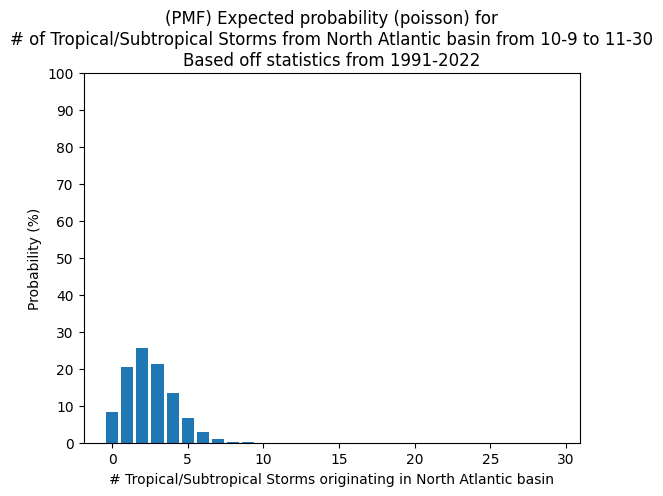

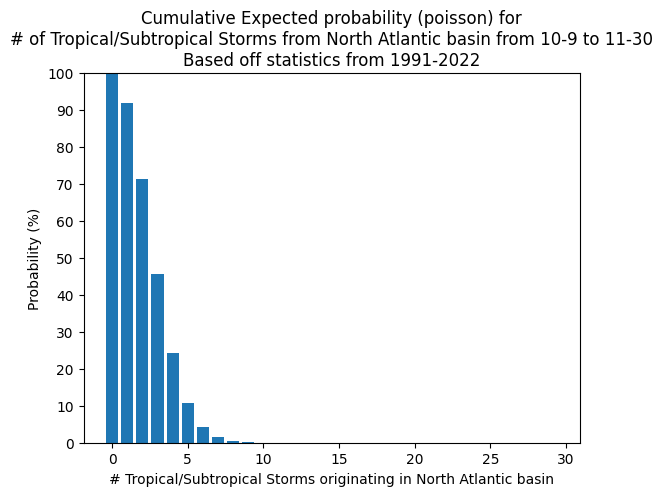

# US Hurricane in records from North Atlantic basin: 963
# US Hurricane from North Atlantic basin, 1991 to 2022 from 10-9 to 11-30: 49
PMF % (starting from 0): [21.62651668298873, 33.115603670826495, 25.354134060476536, 12.941172593368231, 4.954042633398776, 1.517175556478375, 0.38719584514291866, 0.08469909112501345, 0.016211935410647103, 0.0027582806775059312, 0.0004223617287430957, 5.879467246707868e-05, 7.502445184601184e-06, 8.837014760708124e-07, 9.665484894524514e-08, 9.866849163160438e-09, 9.44288298818089e-10, 8.505537985677639e-11, 7.235613911427159e-12, 5.831333579933072e-13, 4.464614772136258e-14, 3.255448271349355e-15, 2.2658659843198633e-16, 1.5085249080390392e-17, 9.624703189311581e-19, 5.895130703453343e-20, 3.471891880639589e-21, 1.9690127563812484e-22, 1.0768038511459951e-23, 5.685709989887258e-25]
Cumulative % (starting from 0): [100.0, 78.37348331701128, 45.25787964618478, 19.903745585708247, 6.962572992340016, 2.0085303589412398, 0.49135480246286467, 0.104158957319

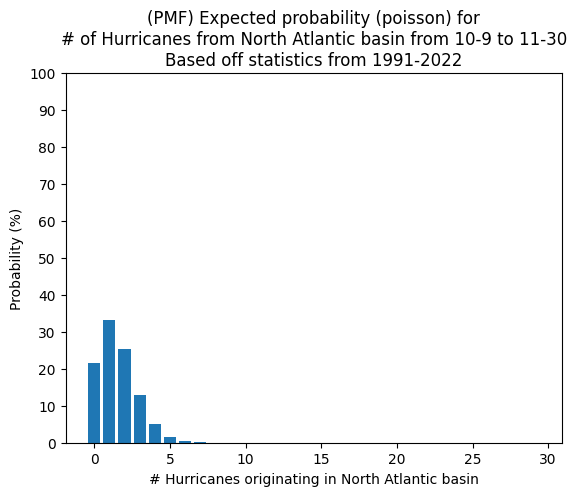

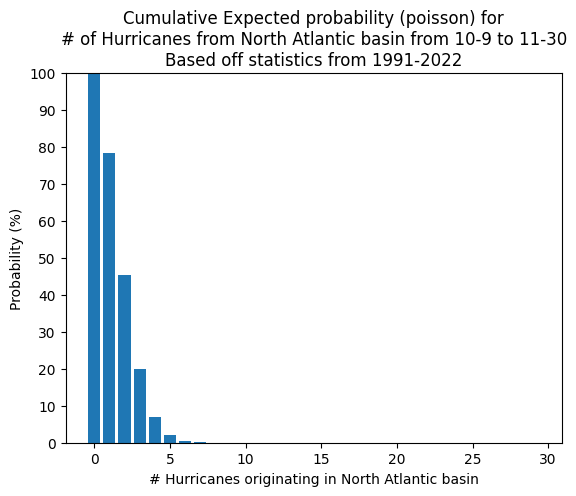

# US Named Storm in records from North Atlantic basin: 1741
# US Named Storm from North Atlantic basin, 1991 to 2022 from 10-9 to 11-30: 80
PMF % (starting from 0): [8.20849986238988, 20.5212496559747, 25.651562069968374, 21.376301724973644, 13.360188578108529, 6.6800942890542645, 2.783372620439277, 0.9940616501568845, 0.3106442656740264, 0.08629007379834068, 0.02157251844958517, 0.004902845102178447, 0.001021426062953843, 0.00019642808902958526, 3.507644446956879e-05, 5.8460740782614655e-06, 9.13449074728354e-07, 1.3433074628358143e-07, 1.8657048094941867e-08, 2.4548747493344564e-09, 3.0685934366680704e-10, 3.653087424604846e-11, 4.1512357097782344e-12, 4.512212728019819e-13, 4.700221591687312e-14, 4.700221591687312e-15, 4.519443838160877e-16, 4.18467022051933e-17, 3.7363126968922586e-18, 3.220959221458844e-19]
Cumulative % (starting from 0): [99.99999999999999, 91.7915001376101, 71.2702504816354, 45.61868841166702, 24.24238668669338, 10.88219810858485, 4.202103819530586, 1.4187311990

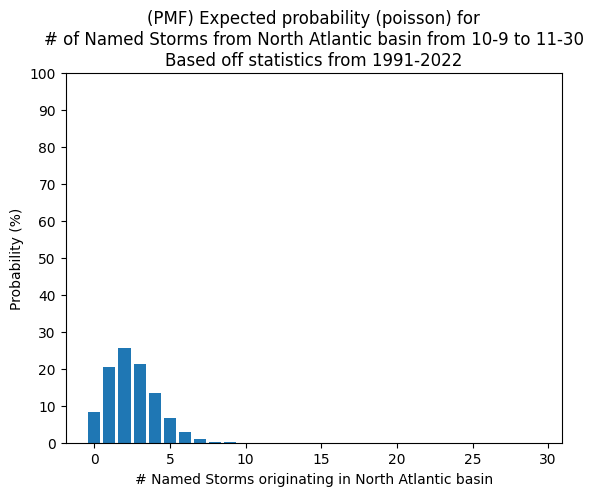

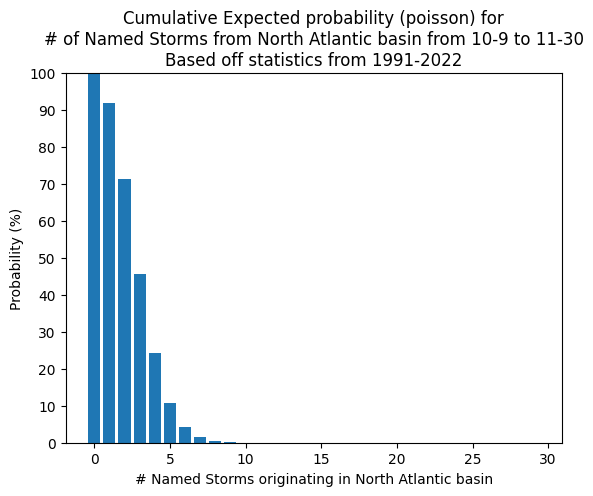

In [12]:
##### BY BASIN STATISTICS FOR STORM TYPES
# Currently, this only counts storms originating in NA basin,
#   and doesn't consider whether the storm crosses basins or which basin it strengthens in
#  Also, this only counts when the storm is at that intensity classification,
#    not necessarily when it first becomes that strength,
#    that is, it doesn't consider genesis of TS or strengthening into a hurricane timeframes,
#    just that the storm was classified such in the time frame
# set optionally either to None (default 1991-2022)
start_year = 1991
end_year = 2022
# must include all as None or with numbered month and day
start_month = None
start_day = None
end_month = None
end_day = None
start_month = 10
start_day = 9
end_month = 11
end_day = 30
# don't condition on states/landfall (don't check states)
states=None

if start_month and start_day and end_month and end_day:
    sub_period_str = f'from {start_month}-{start_day} to {end_month}-{end_day}'
else:
    sub_period_str = 'in a year'

for basin_name, dict_dfs in dfs_by_basin.items():
    storm_types = {'TS/SS': 'Tropical/Subtropical Storm', 'HU': "Hurricane", "NAMED": "Named Storm"}
    storm_type_short_to_dict_key_mapping = {'TS/SS': 'ts_ss', 'HU': 'hu', 'NAMED': 'ts_ss_hu'}
    basin_mapping = {'NA': 'North Atlantic', 'EP': 'East Pacific'}
    full_basin_name = basin_mapping[basin_name]
    for storm_type_short, storm_type_long in storm_types.items():
        df_ref_with_state = dict_dfs[storm_type_short_to_dict_key_mapping[storm_type_short]].copy(deep=True)
        # with state has duplicate rows to record storms with multiple landfalls, so get only the unique storms for a count
        df_unique_storms = df_ref_with_state.drop_duplicates(subset=['USA_ATCF_ID'])
        df_unique_storms.reset_index()
        print(f"# US {storm_type_long} in records from {full_basin_name} basin:", len(df_unique_storms))
        
        storms_in_period = get_landfalling_conditional(
            df_ref_with_state,
            states=states,
            start_year=start_year, end_year=end_year,
            start_month_num=start_month, start_day_num_of_month=start_day,
            end_month_num=end_month, end_day_num_of_month=end_day
        )
        num_years = (end_year - start_year + 1)
        num_in_period = len(storms_in_period)
        #for i in range(len(storms_in_period)):
        #    print(f"{storms_in_period.iloc[i]['SEASON']} : {storms_in_period.iloc[i]['USA_ATCF_ID']}")
        print(f"# US {storm_type_long} from {full_basin_name} basin, {start_year} to {end_year} {sub_period_str}:", num_in_period)

        event_counts = list(range(0,30))
        pmf_pct_per_event_count = []
        cum_pct_per_event_count = []
        pct_total = 0
        for n in event_counts:
            pct = 100 * poisson_pmf(num_years, num_in_period, n)
            pct_total += pct
            pmf_pct_per_event_count.append(pct)

        remaining_pct = pct_total
        # get cumulative probability from pmf
        for pct in pmf_pct_per_event_count:
            cum_pct_per_event_count.append(remaining_pct)
            remaining_pct = remaining_pct - pct

        print("PMF % (starting from 0):", pmf_pct_per_event_count)
        print("Cumulative % (starting from 0):", cum_pct_per_event_count)
        # Create a bar chart
        # PMF
        plt.bar(event_counts, pmf_pct_per_event_count)
        
        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 10))

        # Label the axes and give the chart a title
        plt.xlabel(f'# {storm_type_long}s originating in {full_basin_name} basin')
        plt.ylabel('Probability (%)')
        plt.title(f"(PMF) Expected probability (poisson) for\n# of {storm_type_long}s from " +
                  f"{full_basin_name} basin {sub_period_str}\n" +
                  f"Based off statistics from {start_year}-{end_year}")
        
        # Show the chart
        plt.show()
        
        # Cumulative Probabilities chart
        plt.bar(event_counts, cum_pct_per_event_count)

        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 10))

        # Label the axes and give the chart a title
        plt.xlabel(f'# {storm_type_long}s originating in {full_basin_name} basin')
        plt.ylabel('Probability (%)')
        plt.title(f"Cumulative Expected probability (poisson) for\n# of {storm_type_long}s from " +
                  f"{full_basin_name} basin {sub_period_str}\n" +
                  f"Based off statistics from {start_year}-{end_year}")

        
        # Show the chart
        plt.show()